In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "09_05_2024",
                'genotype_dir': 'EPG_jGCaMP7b_VK05/epinastine_pharmacology/epinastine',
                'fly': 'fly1',
                'session': 'dark-001',
                'full_genotype': '+/w-; +/EPG-AD; UAS-jGCaMP7b^{vk00005}/EPG-DBD (SS00096)',
                'ecl date': '5/3/2024',
                'notes': '100 microM epinastine',
                'fictrac_scan_num': 2,
                'fictrac_dat_file' : 'fictrac-20240509_113325.dat',
               }

session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'])


In [3]:
if True:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]
    pp.extract_timeseries(max_proj=True)
    y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)
    print(pp.session_info)

{'date': '09_05_2024', 'genotype_dir': 'EPG_jGCaMP7b_VK05/epinastine_pharmacology/epinastine', 'fly': 'fly1', 'session': 'dark-001', 'full_genotype': '+/w-; +/EPG-AD; UAS-jGCaMP7b^{vk00005}/EPG-DBD (SS00096)', 'ecl date': '5/3/2024', 'notes': '100 microM epinastine', 'fictrac_scan_num': 1, 'fictrac_dat_file': 'fictrac-20240509_113325.dat', 'fictrac_dir': '/media/mplitt/SSD_storage/fictrac_folder/EPG_jGCaMP7b_VK05/epinastine_pharmacology/epinastine/09_05_2024/fly1'}


In [4]:
# pp.session_info['notes']='control saline'
# print(pp.session_info)

In [14]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
# pp.align_fictrac()

In [15]:
print('')

In [16]:
nap = pp.open_napari()

TypeError: 'NoneType' object is not subscriptable

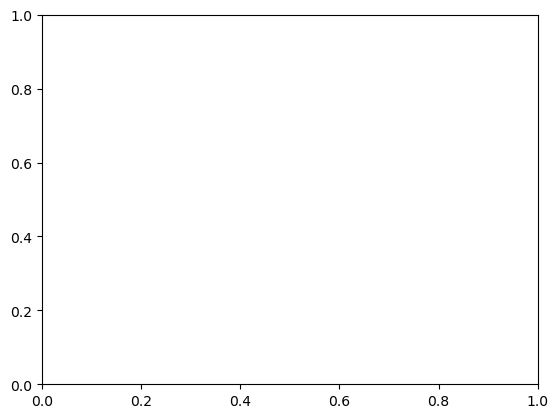

In [17]:
fig, ax = plt.subplots()
time = pp.fictrac_aligned['Time(ms)']
inds = slice(0,100000)
ax.plot(time[inds],pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Heading'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Y/Index'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Arena DAC1'].iloc[inds])

In [ ]:
print('')

In [18]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [19]:
np.isnan(pp.timeseries['rois']).sum()

0

In [20]:
y = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=False)

In [21]:
pp.save()

In [4]:
# y_sm = sp.ndimage.gaussian_filter1d(-1*sp.ndimage.gaussian_filter1d(y, 1, axis=-1),.7,axis=1, mode='wrap')
y_sm = sp.ndimage.gaussian_filter1d(y-1, 1, axis=-1)

x_f,y_f = st2p.utilities.pol2cart(y_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()

_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(3342,) (3342,)


Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(1, 16, 3342) (3342,)


(array([232., 485., 333., 222., 176., 269., 177.,  98.,  85.,  83.]),
 array([-3.14103598e+00, -2.51283145e+00, -1.88462693e+00, -1.25642240e+00,
        -6.28217872e-01, -1.33455075e-05,  6.28191181e-01,  1.25639571e+00,
         1.88460023e+00,  2.51280476e+00,  3.14100929e+00]),
 <BarContainer object of 10 artists>)

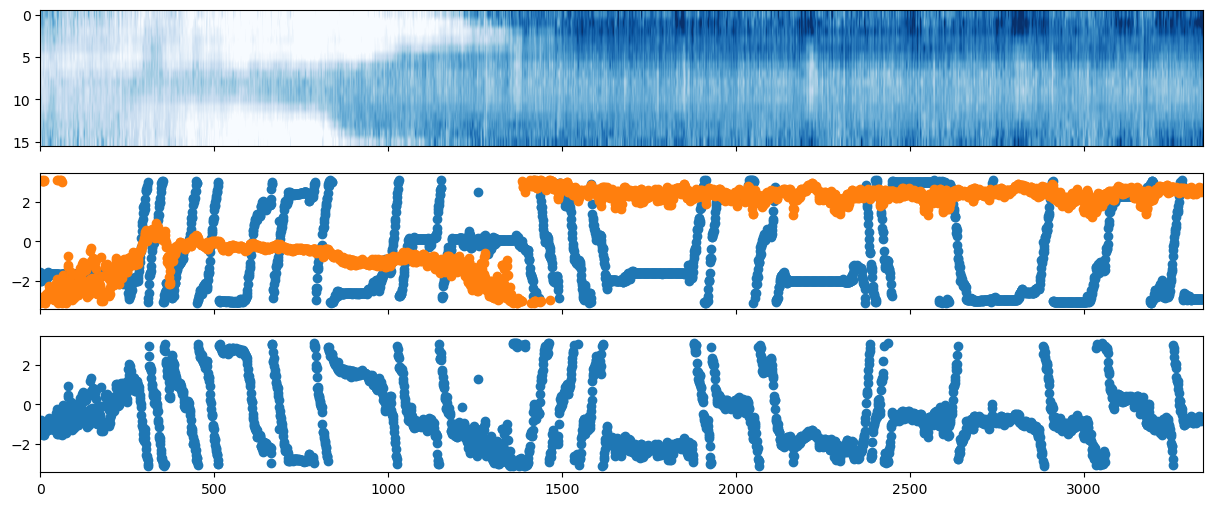

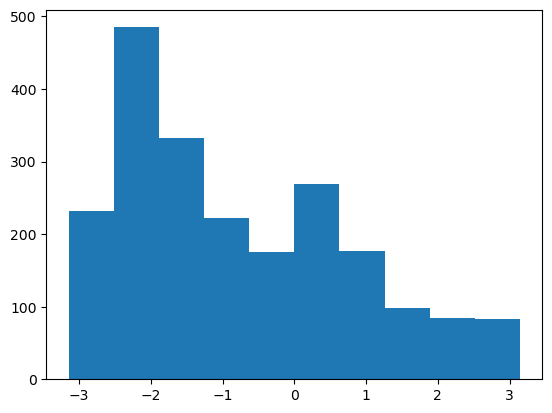

In [5]:
fig, ax= plt.subplots(3,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm[0,::-1,:], aspect='auto', cmap= 'Blues', vmin=-.5, vmax=.7)
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[1].scatter(x,heading)
ax[1].scatter(x, phi)
ax[2].scatter(x, offset)

mask = (heading>-3*np.pi/4) & (heading<3*np.pi/4)
fig, ax= plt.subplots()
ax.hist(offset[mask])

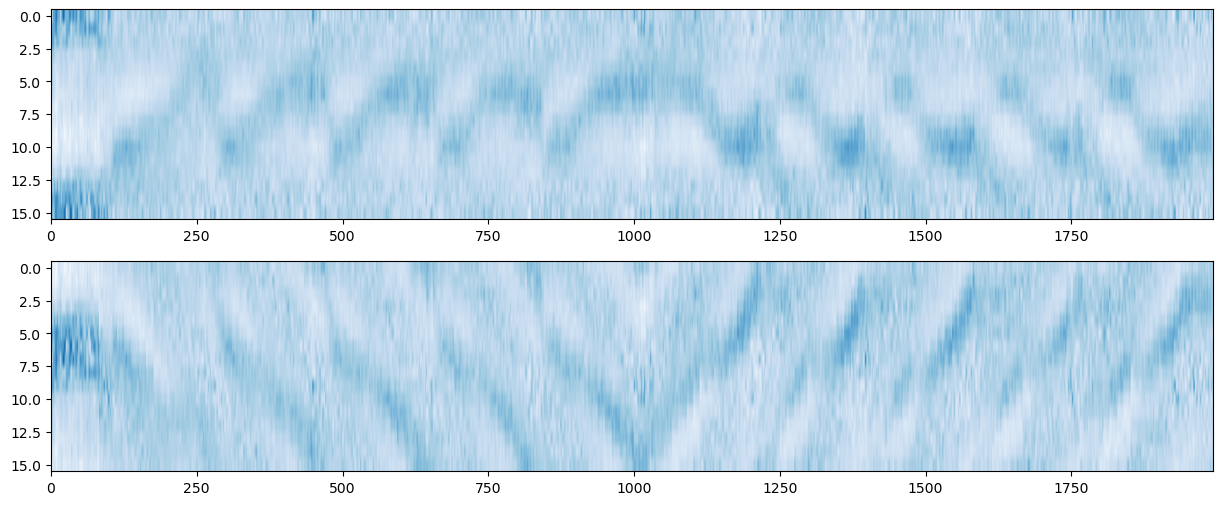

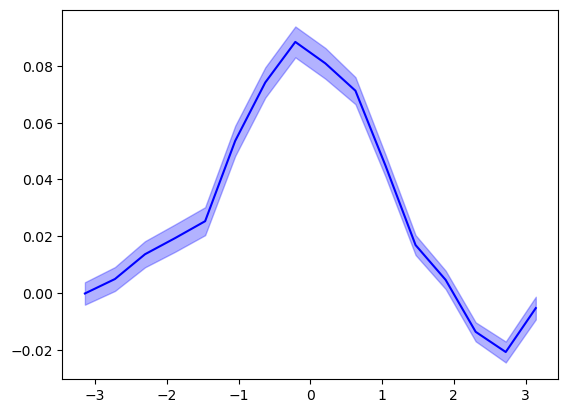

In [24]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)
# print(heading_ind, y_sm.shape)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[0,:,ind] = np.roll(y_sm[0,:,ind], -heading_ind[ind])
    
fig, ax= plt.subplots(2,1, figsize=[15,6])
ax[0].imshow(y_sm[0,:, :] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')
ax[1].imshow(y_sm_heading_aligned[0,:,:] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,:].mean(axis=-1)[0,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,:], axis=-1)[0,:]
# print(mu.shape, sem.shape)
# fig, ax = plt.subplots()
# ax.imshow(y_sm_heading_aligned[:,:,mask][0,:,:], cmap='Blues', aspect='auto')

fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')

In [25]:
print(sp.stats.circvar(offset))

0.7514980518238648
